In [17]:
import os
import random
import requests
import time
import ast
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageFile 

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import matplotlib.pyplot as plt                        
%matplotlib inline

In [18]:
transform = transforms.Compose([
                transforms.Resize(224),
                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [19]:
import pandas as pd

dframe = pd.read_csv('D:/Downloads/dog_breed/labels.csv')
labelnames = pd.read_csv('D:/Downloads/dog_breed/sample_submission.csv').keys()[1:]
codes = range(len(labelnames))

In [20]:
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
dframe['target'] =  [breed_to_code[x] for x in dframe.breed]

In [21]:
cut = int(len(dframe)*0.8)
train, val = np.split(dframe, [cut], axis=0)
val = val.reset_index(drop=True)

In [22]:

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [23]:
'''
class labeltodogs(Dataset):
    """Dog breed identification dataset."""

    def __init__(self, img_dir, dataframe, transform=None):
        
        self.labels_frame = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_frame.id[idx]) + ".jpg"
        image = Image.open(img_name)
        label = self.labels_frame.target[idx]

        if self.transform:
            image = self.transform(image)

        return image, label 
        
'''

class DogBreed:
    def __init__(self, train, transform=None):
        self.train = train
        self.transform = transform
  
    def __len__(self):
        return len(self.train)
  
    def __getitem__(self, idx):
        img_name = self.train.loc[idx]
        path = os.path.join('D:/Downloads/dog_breed/train/', img_name['id']+'.jpg')
        x = Image.open(path)
        y = img_name['target']   
        if self.transform:
            x = self.transform(x)
            y = torch.tensor(y)
        data = {'x':x, 'y':y}
        return data
    

In [24]:
train.iloc[0]['id']

'000bec180eb18c7604dcecc8fe0dba07'

In [25]:
train_ds = DogBreed(train,transform=train_transforms)
val_ds = DogBreed(val,transform=test_transforms)

In [26]:
trainloader = DataLoader(train_ds, batch_size=64, shuffle=True)
testloader = DataLoader(val_ds, batch_size=64, shuffle=True)

In [27]:
trainloader

In [28]:
from torchvision import datasets,models

model = models.vgg11(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

In [29]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


In [30]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [31]:
from torch.nn import Sequential
model.classifier = Sequential(nn.Linear(25088,4096),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(4096,120),
                              nn.LogSoftmax(dim=1))



criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
model.cuda()
epochs = 20

train_losses,test_losses = [],[]

for epoch in range(epochs):
    running_loss = 0
    for data in trainloader:
        images,labels = data['x'],data['y']
        #print(data['y'])
        images = images.cuda()
        labels = labels.cuda()
        #images = images.cuda()
        #labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for images,labels in validloader:
                #images = images.cuda()
                #labels = labels.cuda()
                output = model(images)
                loss = criterion(output,labels)
                test_loss += loss.item()
                ps = torch.exp(output)
                top_v,top_class = ps.topk(1,dim=1)
                result = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(result.type(torch.FloatTensor)).item()
        test_losses.append(test_loss)
        train_losses.append(running_loss)
        model.train()

        print(f"Epoch: {epoch+1}/{epochs}",
                   "test loss: ",test_loss/len(validloader),
                   "train loss: ",running_loss/len(validloader),
                   "accuracy: ",accuracy/len(validloader))


KeyboardInterrupt: 

lakeland_terrier
Shape of the image is:  (500, 375)


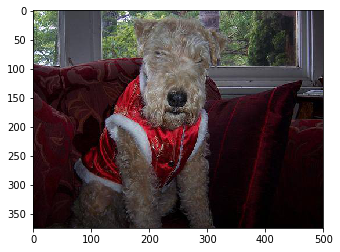

In [8]:
idx = 47
plt.imshow(train_ds[idx][0])
print(code_to_breed[train_ds[idx][1]])
print("Shape of the image is: ", train_ds[idx][0].size)

C:\Users\vinay\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:618: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [10]:
train_ds = labeltodogs('D:/Downloads/dog_breed/train', train, data_transform)
test_ds = labeltodogs('D:/Downloads/dog_breed/train', test, data_transform)
datasets = {"train": train_ds, "val": test_ds}

idx = 49
print(code_to_breed[train_ds[idx][1]])
print("Shape of the image is: ", train_ds[idx][0].shape)

norwegian_elkhound
Shape of the image is:  torch.Size([3, 224, 224])


In [11]:
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True,num_workers=4)

testloader = DataLoader(test_ds, batch_size=1, shuffle=True,num_workers=4)

dataloaders = {"train": trainloader, "val": testloader}

In [12]:
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


In [1]:
from torchvision import datasets,models

model = models.vgg11(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

In [2]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [3]:
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [20]:
net.cpu()

NameError: name 'net' is not defined

In [22]:
from torch.nn import Sequential
model.classifier = Sequential(nn.Linear(25088,4096),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(4096,120),
                              nn.LogSoftmax(dim=1))



criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.003)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:     
            since_epoch = time.time()
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
    
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                inputs = Variable(inputs.type(Tensor))
                labels = Variable(labels.type(LongTensor))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects / len(datasets[phase])

            time_elapsed_epoch = time.time() - since_epoch
            print('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, time_elapsed_epoch // 60, time_elapsed_epoch % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


BrokenPipeError: [Errno 32] Broken pipe